Primero se descarga el dataset usando la API de kaggle y se descomprime.

Luego se copia el cache de los tamannos de imagenes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install rasterio
!pip install opencv-python
!pip install tensorflow
!pip install h5py


In [ ]:
import cv2
import matplotlib.pyplot as plt
import h5py
import numpy as np
import os
import tensorflow as tf
import json

metrics.py


In [ ]:
from keras import backend as K

smooth_default = 1e-12

def jacc_coef(y_true, y_pred, smooth = smooth_default):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) - intersection + smooth)

def dice_coef(y_true, y_pred, smooth = smooth_default, per_batch = True):
    if not per_batch:
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    else:
        y_true_f = K.batch_flatten(y_true)
        y_pred_f = K.batch_flatten(y_pred)
        intersec = 2. * K.sum(y_true_f * y_pred_f, axis=1, keepdims=True) + smooth
        union = K.sum(y_true_f, axis=1, keepdims=True) + K.sum(y_pred_f, axis=1, keepdims=True) + smooth
        return K.mean(intersec / union)

def jacc_loss(y_true, y_pred):
    return 1.0 - jacc_coef(y_true, y_pred)

acc = tf.keras.metrics.BinaryAccuracy(threshold=0.6)

def sensitivity(y_true, y_pred, threshold=0.6, smooth=smooth_default):
    true = tf.cast(y_true, tf.float32)
    pred = tf.cast(y_pred > threshold, tf.float32)

    f_true = K.batch_flatten(true)
    f_pred = K.batch_flatten(pred)
    TP = K.sum(f_true * f_pred, axis=1, keepdims=True)
    f_pred = 1.0 - f_pred
    FN = K.sum(f_true * f_pred, axis=1, keepdims=True)

    return (TP + smooth) / (FN + TP + smooth)

def specificity(y_true, y_pred, threshold=0.6, smooth=smooth_default):
    true = tf.cast(y_true, tf.float32)
    pred = tf.cast(y_pred > threshold, tf.float32)

    f_true = K.batch_flatten(true)
    f_pred = K.batch_flatten(pred)
    f_true = 1.0 - f_true

    FP = K.sum(f_true * f_pred, axis=1, keepdims=True)
    f_pred = 1.0 - f_pred
    TN = K.sum(f_true * f_pred, axis=1, keepdims=True)

    return (TN + smooth) / (TN + FP + smooth)

Modelo

In [ ]:
from keras import Input, Model
from keras import layers
from keras.optimizers import Adam

ISZ = 160
CH = 3

def get_unet():
    inputs = Input(shape=(ISZ, ISZ, CH))
    conv1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu', data_format='channels_last')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv1)

    pool1 = layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv1)
    conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu', data_format='channels_last')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv2)

    pool2 = layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv2)
    conv3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu', data_format='channels_last')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv3)

    pool3 = layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv3)
    conv4 = layers.Conv2D(256, (3, 3), padding='same', activation='relu', data_format='channels_last')(pool3)
    conv4 = layers.Conv2D(256, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv4)

    pool4 = layers.MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(conv4)
    conv5 = layers.Conv2D(512, (3, 3), padding='same', activation='relu', data_format='channels_last')(pool4)
    conv5 = layers.Conv2D(512, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv5)

    up5 = layers.UpSampling2D(size=(2, 2), data_format='channels_last')(conv5)
    up5 = layers.concatenate([conv4, up5])
    conv6 = layers.Conv2D(256, (3, 3), padding='same', activation='relu', data_format='channels_last')(up5)
    conv6 = layers.Conv2D(256, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv6)

    up6 = layers.UpSampling2D(size=(2, 2), data_format='channels_last')(conv6)
    up6 = layers.concatenate([conv3, up6])
    conv7 = layers.Conv2D(128, (3, 3), padding='same', activation='relu', data_format='channels_last')(up6)
    conv7 = layers.Conv2D(128, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv7)

    up7 = layers.UpSampling2D(size=(2, 2), data_format='channels_last')(conv7)
    up7 = layers.concatenate([conv2, up7])
    conv8 = layers.Conv2D(64, (3, 3), padding='same', activation='relu', data_format='channels_last')(up7)
    conv8 = layers.Conv2D(64, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv8)

    up8 = layers.UpSampling2D(size=(2, 2), data_format='channels_last')(conv8)
    up8 = layers.concatenate([conv1, up8])
    conv9 = layers.Conv2D(32, (3, 3), padding='same', activation='relu', data_format='channels_last')(up8)
    conv9 = layers.Conv2D(32, (3, 3), padding='same', activation='relu', data_format='channels_last')(conv9)

    model = layers.Conv2D(1, (1,1), activation='sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=model)
    model.compile(optimizer = Adam(learning_rate=1e-5), loss = 'binary_crossentropy',
                  metrics = ['accuracy', acc, jacc_loss, dice_coef, jacc_coef, sensitivity, specificity])
    return model

#model = get_unet()
#model.summary()

Código de apoyo de Leo

In [ ]:

def load_dataset(path):
    f = h5py.File(path, 'r')
    X_train = f['cities_train']
    y_train = f['cities_train_mask']
    X_val = f['not_cities_train']
    y_val = f['not_cities_train_mask']
    train_ids = f['city_ids']
    val_ids = f['not_city_ids']

    return X_train, y_train, train_ids, X_val, y_val, val_ids  ####################################

def create_and_load(model_creator, weights_path):
    model = model_creator()
    model.load_weights(weights_path)
    return model

def CCCscale(x):
  return (x - np.nanpercentile(x,2))/(np.nanpercentile(x,98) - np.nanpercentile(x,2))

def CCCscaleImg(img):
    img[:,:,0] = CCCscale(img[:,:,0])
    img[:,:,1] = CCCscale(img[:,:,1])
    img[:,:,2] = CCCscale(img[:,:,2])
    return img

def make_prediction(model,X_train, index_index, x,y):
    ori_img = X_train[index_index]
    ori_img = ori_img.transpose(1,2,0)
    mask = model.predict(np.array([ori_img[x:x + 160,y:y + 160,:]]))
    return mask[0,:,:,0]


def comp_img_pred(model,X_train,y_train,index,x,y):
    #PREDICTING MASK
    img = X_train[index]
    img = img.transpose(1,2,0)[x:x + 160,y:y + 160,:]
    pred_mask = model.predict(np.array([img]))

    #PREPARING THE IMAGE
    img = img.astype(np.float32)
    img *=2047
    img = CCCscaleImg(img)

    #CREATING PREDICTED MASK RGB
    mask_rgb = np.zeros((160,160,3))
    mask_rgb[:,:,2] = pred_mask[0,:,:,0]
    mask_rgb = mask_rgb.astype(np.float32)

    #PUTTING DE MASK IN THE IMAGE
    alpha = 0.5
    gamma = 0
    img_result = cv2.addWeighted(img, alpha, mask_rgb, 1 - alpha, gamma)
    img_result = CCCscaleImg(img_result)

    #GETTING REAL MASK
    real = y_train[index]#####################################
    real = real[x:x + 160,y:y + 160]

    #PUTTING THE REAL MASK IN OTHER IMAGE
    new_mask_bool = real == 1
    to_add = np.zeros((*new_mask_bool.shape, 3), dtype=np.uint8)
    to_add[new_mask_bool] = [30, 95, 185]
    to_add = to_add/255
    to_add = to_add.astype(np.float32)
    real_seg = cv2.addWeighted(img, alpha, to_add, 1 - alpha, gamma)
    real_seg = CCCscaleImg(real_seg)

    #PLOTING THE IMAGES
    grid_size = (1, 3)
    plt.subplot2grid(grid_size, (0, 0), rowspan = 1, colspan = 1)
    plt.title('Imagen')
    plt.imshow(img)
    plt.subplot2grid(grid_size, (0, 1), rowspan = 1, colspan = 1)
    plt.title('Real')
    plt.imshow(real_seg)
    plt.subplot2grid(grid_size, (0, 2), rowspan = 1, colspan = 1)
    plt.title('Predicción')
    plt.imshow(img_result)
    plt.savefig('fig')
    plt.show()


In [ ]:
X_train, y_train, train_ids, X_val, y_val, val_ids = load_dataset('/content/drive/MyDrive/splited_train_rgb.h5')
model = create_and_load(get_unet, '/content/drive/MyDrive/last_weight.hdf5')



In [ ]:
def get_img(X_train,index,x,y):
  img = X_train[index]
  img = img.transpose(1,2,0)[x:x + 160,y:y + 160,:]
  return img

def get_mask(y_train,index,x,y):
  real = y_train[index]#####################################
  real = real[x:x + 160,y:y + 160]
  return real

def plot_FP_FN(fp_mask,fn_mask,X_train,img_id,x,y):
  #fp rojo
  #fn azul
    #PREDICTING MASK
  i,j=fp_mask.shape #####################3

  img = X_train[img_id]
  img = img.transpose(1,2,0)[x:x + i,y:y + j,:]

  #PREPARING THE IMAGE
  img = img.astype(np.float32)
  img *=2047
  img = CCCscaleImg(img)

  #CREATING FP RGB RED MASK
  rgb_fp = np.zeros((i,j,3))
  rgb_fp[:,:,0] = fp_mask
  rgb_fp = rgb_fp.astype(np.float32)

  #CREATING FN RGB BLUE MASK
  # rgb_fn = np.zeros((160,160,3))
  rgb_fn = np.zeros((i,j,3))
  rgb_fn[:,:,2] = fn_mask#####################################3 por 2
  rgb_fn = rgb_fn.astype(np.float32)

  #PUTTING THE IN THEMASKING DE IMAGE
  alpha = 0.5 #TRANSPARENCE
  gamma = 0  #IDK
  img_result = cv2.addWeighted(img, alpha, rgb_fp, 1 - alpha, gamma)
  img_result = cv2.addWeighted(img_result, alpha, rgb_fn, 1 - alpha, gamma)
  img_result = CCCscaleImg(img_result)

  grid_size = (1, 2)
  plt.subplot2grid(grid_size, (0, 0), rowspan = 1, colspan = 1)
  plt.title('Imagen')
  plt.imshow(img)
  plt.subplot2grid(grid_size, (0, 1), rowspan = 1, colspan = 1)
  plt.title('FP(RED)/FN(BLUE)')
  plt.imshow(img_result)
  plt.savefig('fig')
  plt.show()



def save_json(data,name):
  for i in data.keys():
    for x in data[i].keys():
      for y in data[i][x].keys():
        data[i][x][y] = data[i][x][y].tolist()

  with open(f'{name}.json', 'w') as f:
    json.dump(data, f)


In [ ]:
def get_all_predictions(model,X_train,y_train):
  l1, l2, l3, l4 = X_train.shape
  # l1=1  ####borrar
  # l3=400   ###borrar
  # l4=400   ####borrar

  predictions:dict={}
  for i in range(l1):
    predictions[i] = {}
    x=0
    while(x<l3):
      predictions[i][x]={}
      y=0
      rx = x
      if l3-160 < x:
        x = l3-160

      while(y<l4):
        ry = y
        if l4-160 < y:
          y = l4-160

        prediction = make_prediction(model,X_train, i , x,y)

        if rx != x:
          prediction = prediction[rx-x:,:]

        if ry != y:
          prediction = prediction[:,ry-y:]

        predictions[i][rx][ry] = prediction

        if ry != y:
          break
        y+=160

      if rx != x:
        break
      x+=160

  return predictions



Las predicciones se guardan en un diccionario que tiene como primera llave `img_id` o lo que sería la imagen actual, este valor es nuevamente un diccionario que tiene como llave la coordenada `x` del punto `x_0` en el que se comienza este fragmento de la imagen y este igualmente tiene como valor un diccionario cuya llave es la coordenada `y` del punto `y_0` en el que se comienza este fragmento de la imagen, para finalmente obtener la máscara de la predicción de la imagen `img_id` que comienza en `(x_0,y_0)`

In [ ]:
predictions_cities_train = get_all_predictions(model,X_train,y_train)

save_json(predictions_cities_train,"predictions_cities_train")



1/1 [==============================] - 0s 253ms/step


In [ ]:
predictions_not_cities_val = get_all_predictions(model,X_val,y_val)
save_json(predictions_not_cities_val,"predictions_not_cities_val")


In [ ]:

def search_fp_fn(image, real, prediction,threshold):
  rows,cols = prediction.shape
  fp = np.zeros((rows,cols))
  fn = np.zeros((rows,cols))
  for i in range(rows):
    for j in range(cols):
      pred_val = 1 if prediction[i,j]>threshold else 0
      fp[i,j]= 1 if (pred_val and (not real[i,j])) else 0
      fn[i,j]= 1 if (real[i,j] and (not pred_val)) else 0
  return fp,fn

def search_all_fp_fn(data,X_train,y_train,threshold):
  fp_fn :dict = {}
  for i in data.keys():
    fp_fn[i]={}
    for x in data[i].keys():
      fp_fn[i][x]={}
      for y in data[i][x].keys():

        prediction = data[i][x][y]

        real = get_mask(y_train,i,x,y)
        image = get_img(X_train,i,x,y)
        fp,fn = search_fp_fn(image, real, prediction,threshold)
        fp_fn[i][x][y] = [fp,fn]

  return fp_fn


In [ ]:
threshold = 0.3
fp_fn_cities_train = search_all_fp_fn(predictions_cities_train,X_train,y_train,threshold)
save_json(fp_fn_cities_train,"fp_fn_cities_train")


In [ ]:
threshold = 0.3
fp_fn_not_cities_val = search_all_fp_fn(predictions_not_cities_val,X_val,y_val,threshold)
save_json(fp_fn_not_cities_val,"fp_fn_not_cities_val")


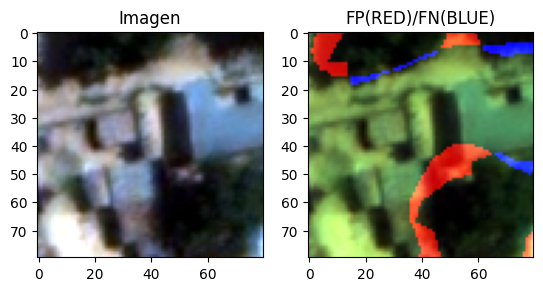

1/1 [==============================] - 0s 262ms/step


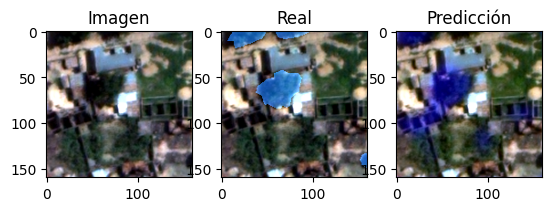

In [101]:
img_id=0
x=320
y=320

fp_mask, fn_mask = fp_fn_cities_train[img_id][x][y]

plot_FP_FN(fp_mask,fn_mask,X_train,img_id,x,y)
comp_img_pred(model,X_train,y_train,img_id,x,y)

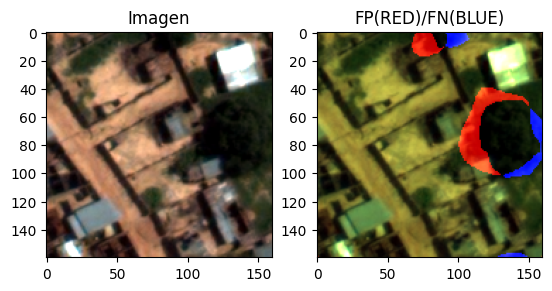

1/1 [==============================] - 0s 238ms/step


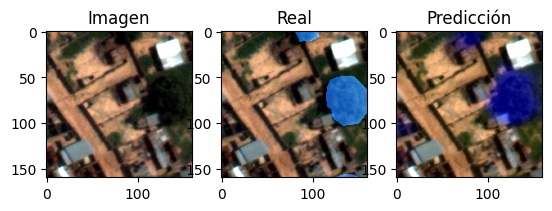

In [ ]:
img_id=0
x=0 #160
y=0 #160

fp_mask, fn_mask = fp_fn_cities_train[img_id][x][y]

plot_FP_FN(fp_mask,fn_mask,X_train,img_id,x,y)
comp_img_pred(model,X_train,y_train,img_id,x,y)